# Michael Harris 
# BAX-423
# Homework # 2
# April 13, 2021

# Question 1: Setting Up Spark and End-to-End Example

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession\
        .builder\
        .getOrCreate()

In [7]:
# Import the Flight Data File.

from google.colab import files
files.upload()

Saving 2015-summary.csv to 2015-summary.csv


{'2015-summary.csv': b'DEST_COUNTRY_NAME,ORIGIN_COUNTRY_NAME,count\nUnited States,Romania,15\nUnited States,Croatia,1\nUnited States,Ireland,344\nEgypt,United States,15\nUnited States,India,62\nUnited States,Singapore,1\nUnited States,Grenada,62\nCosta Rica,United States,588\nSenegal,United States,40\nMoldova,United States,1\nUnited States,Sint Maarten,325\nUnited States,Marshall Islands,39\nGuyana,United States,64\nMalta,United States,1\nAnguilla,United States,41\nBolivia,United States,30\nUnited States,Paraguay,6\nAlgeria,United States,4\nTurks and Caicos Islands,United States,230\nUnited States,Gibraltar,1\nSaint Vincent and the Grenadines,United States,1\nItaly,United States,382\nUnited States,Federated States of Micronesia,69\nUnited States,Russia,161\nPakistan,United States,12\nUnited States,Netherlands,660\nIceland,United States,181\nMarshall Islands,United States,42\nLuxembourg,United States,155\nHonduras,United States,362\nThe Bahamas,United States,955\nUnited States,Senegal,4

Question 1: Running the End-to-End Example


In [8]:
# Import in the Flight Data 2015 file from the textbook. 

flightData2015 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("2015-summary.csv")
flightData2015.head(5)


[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344),
 Row(DEST_COUNTRY_NAME='Egypt', ORIGIN_COUNTRY_NAME='United States', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='India', count=62)]

In [9]:
# Take 3 records from the CSV.
flightData2015.take(3)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Romania', count=15),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Croatia', count=1),
 Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Ireland', count=344)]

In [10]:
# Explain the 'Count column.
flightData2015.sort("count").explain()

== Physical Plan ==
*(1) Sort [count#18 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#18 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#38]
   +- FileScan csv [DEST_COUNTRY_NAME#16,ORIGIN_COUNTRY_NAME#17,count#18] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/content/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [11]:
# Set Shuffle Partition to 5 and take 2 records.
spark.conf.set("spark.sql.shuffle.partitions", "5")
flightData2015.sort("count").take(2)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1),
 Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1)]

In [12]:
# Make our dataframe into a table.
flightData2015.createOrReplaceTempView("flight_data_2015")

In [13]:
# Explain SQL query in SQL way and Dataframe way.

sqlWay = spark.sql("""
SELECT DEST_COUNTRY_NAME, count(1)
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
""")

dataFrameWay = flightData2015\
.groupBy("DEST_COUNTRY_NAME")\
.count()

sqlWay.explain()
dataFrameWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#16, 5), ENSURE_REQUIREMENTS, [id=#67]
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[partial_count(1)])
      +- FileScan csv [DEST_COUNTRY_NAME#16] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/content/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>


== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#16, 5), ENSURE_REQUIREMENTS, [id=#86]
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[partial_count(1)])
      +- FileScan csv [DEST_COUNTRY_NAME#16] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/content/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [14]:
# Output the maximum number of flights to any one location. 
from pyspark.sql.functions import max
flightData2015.select(max("count")).take(1)

[Row(max(count)=370002)]

In [15]:
# Using the SQL Query way, group count of flights by Destination Country Name.

maxSql = spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
ORDER BY sum(count) DESC
LIMIT 5
""")
maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [16]:
# Using the Dataframe query way, group count of flights by Destination Country Name.


from pyspark.sql.functions import desc

flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .sum("count")\
  .withColumnRenamed("sum(count)", "destination_total")\
  .sort(desc("destination_total"))\
  .limit(5)\
  .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [17]:
# Collect results in our Dataframe.

flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .sum("count")\
  .withColumnRenamed("sum(count)", "destination_total")\
  .sort(desc("destination_total"))\
  .limit(5)\
  .explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[destination_total#101L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#16,destination_total#101L])
+- *(2) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[sum(cast(count#18 as bigint))])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#16, 5), ENSURE_REQUIREMENTS, [id=#194]
      +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#16], functions=[partial_sum(cast(count#18 as bigint))])
         +- FileScan csv [DEST_COUNTRY_NAME#16,count#18] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/content/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>




# Question 2: Writing my own Spark job - SQL Queries

In [18]:
# Import the Global Land Temperatures file.

from google.colab import files
files.upload()


Output hidden; open in https://colab.research.google.com to view.

In [19]:
# Read the File into a CSV and return the first five rows.

GlobalTemp = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("GlobalLandTemperatures_GlobalLandTemperaturesByCountry.csv")
GlobalTemp.head(5)

[Row(dt='1743-11-01', AverageTemperature=4.3839999999999995, AverageTemperatureUncertainty=2.294, Country='Åland'),
 Row(dt='1743-12-01', AverageTemperature=None, AverageTemperatureUncertainty=None, Country='Åland'),
 Row(dt='1744-01-01', AverageTemperature=None, AverageTemperatureUncertainty=None, Country='Åland'),
 Row(dt='1744-02-01', AverageTemperature=None, AverageTemperatureUncertainty=None, Country='Åland'),
 Row(dt='1744-03-01', AverageTemperature=None, AverageTemperatureUncertainty=None, Country='Åland')]

In [20]:
# Make our dataframe into a table.
GlobalTemp.createOrReplaceTempView("global_temp")

# Write SQL Query to display the country with the highest average temperature for any given month.
maxTemp = spark.sql("""
SELECT Country, YEAR(dt), max(AverageTemperature) as Max_Temp
FROM global_temp
where AverageTemperature IS NOT NULL
GROUP BY Country,dt, AverageTemperature
ORDER BY AverageTemperature DESC
LIMIT 1
""")
maxTemp.show()

# This query displays the month with the highest average temperature overall. 

+-------+----------------------+-----------------+
|Country|year(CAST(dt AS DATE))|         Max_Temp|
+-------+----------------------+-----------------+
| Kuwait|                  2012|38.84200000000001|
+-------+----------------------+-----------------+



In [21]:
# However, if we want to sum average temp over the year (and not just return the highest avg month), the following query is needed:

maxTempYear = spark.sql("""
SELECT YEAR(dt) as year, Country, AVG(AverageTemperature) OVER (PARTITION BY YEAR(dt), Country) as Average_Temperature
FROM global_temp
GROUP BY YEAR(dt), Country, AverageTemperature
ORDER BY Average_Temperature DESC
LIMIT 1
""")
maxTempYear.show()


# This shows that the highest average temperature over the course of the entire year was from Djibouti in 2013.

+----+--------+-------------------+
|year| Country|Average_Temperature|
+----+--------+-------------------+
|2013|Djibouti|           30.74475|
+----+--------+-------------------+



In [22]:
# Select the 10 Countries with the largest differences in Average Temperature Range among the analyzed data.


tempDiff = spark.sql("""
select t.Country, min(AvgTemp) as Min_Temp, max(AvgTemp) as Max_Temp, Max(AvgTemp)-Min(AvgTemp) as Range
FROM (SELECT YEAR(dt), Country, AVG(AverageTemperature) OVER (PARTITION BY YEAR(dt), Country) AvgTemp
FROM global_temp
where AverageTemperature IS NOT NULL
GROUP BY YEAR(dt), Country, AverageTemperature) AS t
GROUP BY t.Country
ORDER BY Range Desc
LIMIT 10
""")
tempDiff.show()

+-------------+-------------------+-------------------+------------------+
|      Country|           Min_Temp|           Max_Temp|             Range|
+-------------+-------------------+-------------------+------------------+
|       Canada|            -22.616| 0.7927142857142851|23.408714285714286|
|       Russia|            -21.342|-1.6283333333333334|19.713666666666665|
|   Kazakhstan|             -8.789|  8.937249999999999|          17.72625|
|North America|-11.192666666666668|              6.436|17.628666666666668|
|       Kuwait|              12.02| 27.638666666666676|15.618666666666677|
|   Uzbekistan| 0.8480000000000001|           16.18825|          15.34025|
|United States| -2.774666666666667|             12.231|15.005666666666666|
| Turkmenistan| 3.6929999999999996| 18.613500000000002|14.920500000000002|
|      Algeria|             10.343| 25.215666666666664|14.872666666666664|
|       Jordan|             7.8545| 22.227999999999998|14.373499999999998|
+-------------+----------

# Question 2: Merge the Two Datasets and Find Correlation

In [23]:
# Import the CO2 Emissions File.

from google.colab import files
files.upload()

Saving CO2 emissions per capita per country.csv to CO2 emissions per capita per country.csv


{'CO2 emissions per capita per country.csv': b'\xef\xbb\xbfCountry_Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018\r\nAruba,ABW,,,,,,,,,,,,,,,,,,,,,,,,,,,2.868319392,7.235198033,10.02617921,10.6347326,26.37450321,26.0461298,21.4425588,22.00078616,21.03624511,20.77193616,20.31835337,20.42681771,20.58766915,20.31156677,26.19487524,25.93402441,25.67116178,26.42045209,26.51729342,27.20070778,26.94826047,27.895574,26.23084664,25.91583295,24.67052887,24.5058352,13.15554169,8.351294252,8.408362638,,,,\r\nAfghanistan,AFG,0.046059897,0.053604304,0.073764791,0.074232685,0.086292452,0.101467397,0.107636955,0.123734289,0.11549774,0.08682346,0.150290627,0.166042044,0.13076385,0.136279785,0.155649444,0.168928649,0.154787206,0.182963616,0.1

In [24]:
# Before merging the files, we'll have to transform both files into a Pandas dataframe, stack the data when necessary, and then merge on common columns.

import pandas as pd
CO2 = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("CO2 emissions per capita per country.csv")
CO2.head(5)

[Row(Country_Name='Aruba', Country Code='ABW', 1960=None, 1961=None, 1962=None, 1963=None, 1964=None, 1965=None, 1966=None, 1967=None, 1968=None, 1969=None, 1970=None, 1971=None, 1972=None, 1973=None, 1974=None, 1975=None, 1976=None, 1977=None, 1978=None, 1979=None, 1980=None, 1981=None, 1982=None, 1983=None, 1984=None, 1985=None, 1986=2.868319392, 1987=7.235198033, 1988=10.02617921, 1989=10.6347326, 1990=26.37450321, 1991=26.0461298, 1992=21.4425588, 1993=22.00078616, 1994=21.03624511, 1995=20.77193616, 1996=20.31835337, 1997=20.42681771, 1998=20.58766915, 1999=20.31156677, 2000=26.19487524, 2001=25.93402441, 2002=25.67116178, 2003=26.42045209, 2004=26.51729342, 2005=27.20070778, 2006=26.94826047, 2007=27.895574, 2008=26.23084664, 2009=25.91583295, 2010=24.67052887, 2011=24.5058352, 2012=13.15554169, 2013=8.351294252, 2014=8.408362638, 2015=None, 2016=None, 2017=None, 2018=None),
 Row(Country_Name='Afghanistan', Country Code='AFG', 1960=0.046059897, 1961=0.053604304, 1962=0.073764791,

In [25]:
# The next step is to reshape our dataframe to allow for combining dataframes.

# First, convert to Pandas DataFrame.
CO2_Pandas = CO2.toPandas()

# Next, set index on certain columns so that they are not stacked.
CO2_Pandas = CO2_Pandas.set_index(['Country_Name', 'Country Code'])

# Stack the remaining columns.
CO2_Stacked = CO2_Pandas.stack()

# Reset the index to repeat all line item labels.
CO2_Final = CO2_Stacked.reset_index()

# Rename the columns in our DataFrame.
CO2_Final.columns = ['Country_Name', 'Country Code', 'Year', 'CO2_Emissions']

# Create a Column for the Year and Country - we'll join on this column.
CO2_Final['Year-Country'] = CO2_Final['Country_Name']+' '+CO2_Final['Year']
CO2_Final.head(20)


,Country_Name,Country Code,Year,CO2_Emissions,Year-Country
0,Aruba,ABW,1986,2.86832,Aruba 1986
1,Aruba,ABW,1987,7.2352,Aruba 1987
2,Aruba,ABW,1988,10.0262,Aruba 1988
3,Aruba,ABW,1989,10.6347,Aruba 1989
4,Aruba,ABW,1990,26.3745,Aruba 1990
5,Aruba,ABW,1991,26.0461,Aruba 1991
6,Aruba,ABW,1992,21.4426,Aruba 1992
7,Aruba,ABW,1993,22.0008,Aruba 1993
8,Aruba,ABW,1994,21.0362,Aruba 1994
9,Aruba,ABW,1995,20.7719,Aruba 1995


In [26]:
# Format the Global Temperature data by year. For countries that had null values, or for countries before 1960, we'll remove that data 
# from our combined dataframe.

GlobalTemp_Year = spark.sql("""
SELECT distinct YEAR(dt) as year, Country, AVG(AverageTemperature) OVER (PARTITION BY YEAR(dt), Country) as Average_Temperature
FROM global_temp
WHERE YEAR(dt) > 1959
AND AverageTemperature IS NOT NULL
GROUP BY YEAR(dt), Country, AverageTemperature
ORDER BY Average_Temperature
""")
GlobalTemp_Year.show()

+----+---------+-------------------+
|year|  Country|Average_Temperature|
+----+---------+-------------------+
|1983|Greenland| -20.44683333333333|
|1983|  Denmark|          -19.85775|
|1971|Greenland|-19.710500000000003|
|1992|Greenland|           -19.5845|
|1975|Greenland|-19.524916666666666|
|1989|Greenland|            -19.368|
|1984|Greenland|            -19.326|
|1973|Greenland| -19.27358333333333|
|1993|Greenland|-19.267166666666665|
|1971|  Denmark|          -19.14225|
|1992|  Denmark|-19.000416666666666|
|1982|Greenland|-18.990666666666666|
|1961|Greenland|-18.990333333333332|
|1975|  Denmark|          -18.94575|
|1966|Greenland| -18.84241666666667|
|1968|Greenland| -18.81891666666667|
|1972|Greenland|-18.817999999999998|
|1989|  Denmark|-18.784583333333334|
|1984|  Denmark|-18.769166666666663|
|1970|Greenland|-18.738166666666665|
+----+---------+-------------------+
only showing top 20 rows



In [27]:
# Transform our GlobalTemp file to a Pandas Dataframe.

Temp_Pandas = GlobalTemp_Year.toPandas()
Temp_Pandas.head(5)

# Create a Year & Country variable that we will use to merge the two datasets.
Temp_Pandas['Country-Year'] = Temp_Pandas['Country']+' ' + Temp_Pandas['year'].astype(str)
Temp_Pandas.head(5)


,year,Country,Average_Temperature,Country-Year
0,1983,Greenland,-20.446833,Greenland 1983
1,1983,Denmark,-19.857750,Denmark 1983
2,1971,Greenland,-19.710500,Greenland 1971
3,1992,Greenland,-19.584500,Greenland 1992
4,1975,Greenland,-19.524917,Greenland 1975


In [28]:
# Convert our Pyspark SQL dataframe to Pandas to merge. Then, merge the two datasets by Country, keeping the data from 1960-2014.

combined = pd.merge(Temp_Pandas, CO2_Final, left_on="Country-Year", right_on="Year-Country")
combined.head(5)

,year,Country,Average_Temperature,Country-Year,Country_Name,Country Code,Year,CO2_Emissions,Year-Country
0,1983,Greenland,-20.446833,Greenland 1983,Greenland,GRL,1983,6.968,Greenland 1983
1,1983,Denmark,-19.857750,Denmark 1983,Denmark,DNK,1983,9.81084,Denmark 1983
2,1971,Greenland,-19.710500,Greenland 1971,Greenland,GRL,1971,9.94441,Greenland 1971
3,1992,Greenland,-19.584500,Greenland 1992,Greenland,GRL,1992,8.68675,Greenland 1992
4,1975,Greenland,-19.524917,Greenland 1975,Greenland,GRL,1975,10.2025,Greenland 1975


In [29]:
# Finally, drop out the duplicate columns.
combined_final = combined.drop(columns=['Country-Year','Year-Country', 'Year', 'Country_Name'], axis = 1)

# We now have a final dataframe with CO2 emissions and temperature by year and country. 
combined_final.head(5)

,year,Country,Average_Temperature,Country Code,CO2_Emissions
0,1983,Greenland,-20.446833,GRL,6.968
1,1983,Denmark,-19.857750,DNK,9.81084
2,1971,Greenland,-19.710500,GRL,9.94441
3,1992,Greenland,-19.584500,GRL,8.68675
4,1975,Greenland,-19.524917,GRL,10.2025


# Question 2: Relationship between CO2 Emissions and Average Temperature.

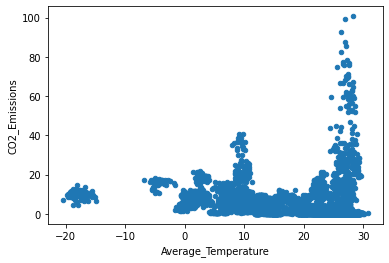

In [30]:
# Determine relationship between CO2 Emissions and Average Temperature.
combined_final.plot.scatter('Average_Temperature', 'CO2_Emissions')

# We observe that average temperature is associated with higher CO2 Emissions.

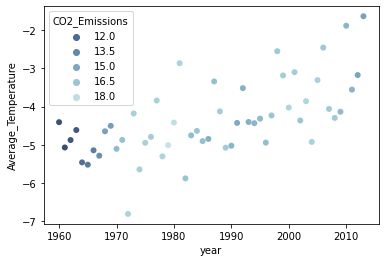

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Next, because there are so many observations - let's analyze this relationship for a specific country, on a subset of our merged data.

combined_final_sns = combined_final[combined_final["Country"] == 'Canada']

sns.scatterplot(x="year", y="Average_Temperature",
                hue="CO2_Emissions",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=combined_final_sns)

# We observe that for Canada, CO2 emissions are increasing along with the Average Temperature.

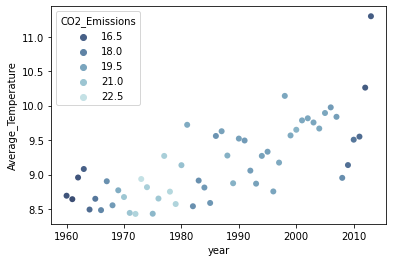

In [32]:
# Let's try running this correlation for the United States.

combined_final_sns = combined_final[combined_final["Country"] == 'United States']

sns.scatterplot(x="year", y="Average_Temperature",
                hue="CO2_Emissions",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=combined_final_sns)

# We observe the same relationship - that as time increases, CO2 emissions and temperature have been increasing together. Though CO2 Emissions have 
# leveled off over the past decade.

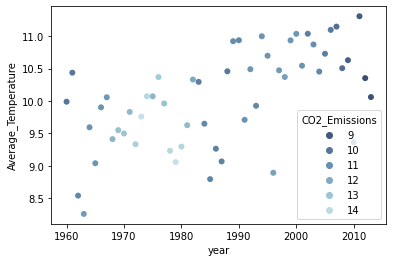

In [33]:
# Last, let's perform this analysis for Belgium.
combined_final_sns = combined_final[combined_final["Country"] == 'Belgium']

sns.scatterplot(x="year", y="Average_Temperature",
                hue="CO2_Emissions",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 8), linewidth=0,
                data=combined_final_sns)

# We observe the same relationship - that as time increases, CO2 emissions and temperature have been increasing together.

In [34]:
# Finally, let's run a Regression between CO2 and Average Temperature for all countries.

# Before doing so, let's convert CO2 Emissions to a float variable.
combined_final["CO2_Emissions"] = pd.to_numeric(combined_final["CO2_Emissions"])
combined_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7844 entries, 0 to 7843
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 7844 non-null   int32  
 1   Country              7844 non-null   object 
 2   Average_Temperature  7844 non-null   float64
 3   Country Code         7844 non-null   object 
 4   CO2_Emissions        7844 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 337.0+ KB


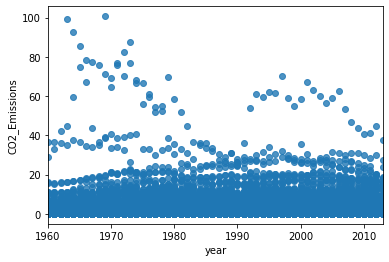

In [35]:
# Let's run a Regression for CO2 Emissions by Year. We notice that it is hard to discern a trend with so many datapoints.

sns.regplot(x="year", y="CO2_Emissions", data=combined_final)

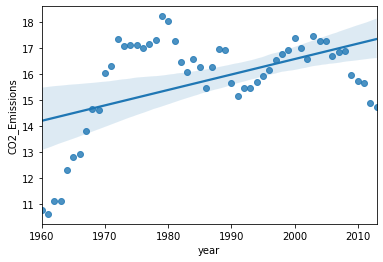

In [36]:
# To resolve, let's look at this trend in a smaller subset - for the country of 'Canada'. 

combined_final_sns = combined_final[combined_final["Country"] == 'Canada']
sns.regplot(x="year", y="CO2_Emissions", data=combined_final_sns)

# Here, a clear relationship emerges that CO2 Emissions are increasing over time, although there has been a reduction or leveling off in recent years.

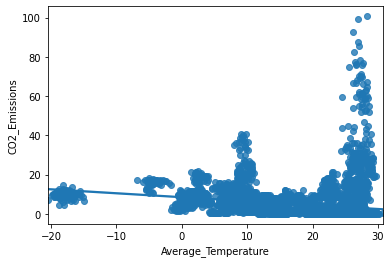

In [37]:
# Regression Plot between Average Temperature and CO2 Emissions for our entire dataset.

sns.regplot(x="Average_Temperature", y="CO2_Emissions", data=combined_final)

# This relationship seems counterintuitive, but is explained by the fact that CO2 Emissions have been flat over the last 5 years in the data, while
# the temperature has been increasing. So it is more difficult to discern a trend at scale. 

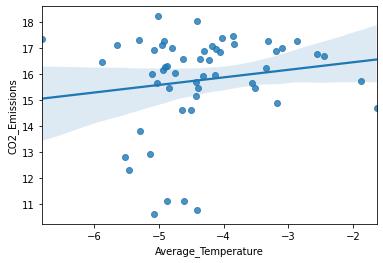

In [38]:
# However, running this regression on the Country Level provides us with a clearer picture of this relationship.
sns.regplot(x="Average_Temperature", y="CO2_Emissions", data=combined_final_sns)

# Here is a graph showing the relationship for Canada.

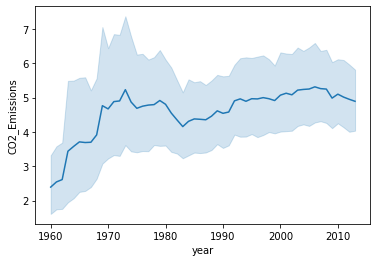

In [39]:
# We observe the increase in CO2 Emissions over the years, but how it has flattened over the last decade - given our data & up to 2014.

sns.lineplot(data=combined_final, x="year", y="CO2_Emissions")


In [41]:
# Finally, let's observe the correlation between Average Temperature and CO2_Emissions on the data as a whole.

print('The correlation between Average Temperature and CO2 Emissions is')
combined_final['Average_Temperature'].corr(combined_final['CO2_Emissions'])

# We observe a weak negative correlation - but again, that can be explained by the fact that CO2 Emissions have stalled in recent years, while temperatures 
# have continued to rise. 

The correlation between Average Temperature and CO2 Emissions is


-0.2344869168960993

Overall, we observe a relationship between CO2 Emissions and Temperature. However, as CO2 Emissions have leveled off in recent years, it has been difficult to discern this relationship at scale, given the data provided. As such, we performed several examples in which we analyzed the relationship for a specific country. We note that simply decreasing our CO2 Emissions now may not be enough to correlate with a reduction in Average Temperatures. Additional corrective action and environmental work may be necessary.

# Question 2: What can I do to make a positive change to the environment?


In my everyday life, there are several things that I do to try to reduce my envionmental impact. I take short showers and try to conserve water whenever possible. I actively recycle and compost any materials that I can, rather than disposing of them in the trash. I don't drive very often, and try to get by by walking around, or through public transport, whenever possible. I use reusable bags when grocery shopping. I always use a refillable water bottle rather than purchase plastic alternatives. These small things help to minimize my environmental impact, but I acknowledge that there is quite a bit more that I could do. 

To take it a step further, I could volunteer my time for a local non-profit, and try to make a greater difference in my community. I could do more research on companies that are implementing clean energy policies, and could restrict my purchasing to those companies whenever possible. I could become more of an advocate than I am, spreading awareness about the impending environmental crisis. 

I truly believe that climate change is the greatest threat that we are facing or perhaps have ever faced, and that it is crucial that we deal with it now, as it may be too late to deal with it later.

# Question 3: Start Thinking about your Final Project

A key outcome of access to resources and information is that costs drop to zero. Rather than fronting the costs yourself, you can instead consolidate the data from other sources that have already gathered it. This involves accessing resources and information that you don't own, and is crucial because information has the potential to quickly double. Businesses are discovering new ways to utilize existing information to improve their business.

Three ideas about new sources of information that can underpin new companies:
1. Access to Census Data & Pulse Surveys.

I believe that access to Census Data and Pulse Surveys could provide an advantage to companies who are looking to expand into new markets. Rather than conducting surveys or gathering the data on the markets themselves, companies can instead consolidate census data as to the population of subgroups in different regions. This would greatly reduce costs, and is a way to utilize existing information to gain an advantage. This could be helpful in our final project if we need to break up information by geographic region, by population, or by subgroup. We could also identify markets to target.

2. Scraping COVID case/death data from sites like Worldometers or John Hopkins .

A company may be able to identify areas of high risk for COVID-19, or to make inferences on how COVID-19 is spreading, by accessing publically available information on the web. If our Project team seeks to incorporate the effects of COVID into our analytics plan or model that we create, it may be very useful to consolidate this information. 

3. Using Satellites to track transportation movement among the population. 

Another idea would be to create a centralized job listing board that scrapes information from various sources across the web. This would provide an overview of the job market that exceeds that of any other site. Lastly, a company could use satellite imagery to track areas of high traffic (by car), and then use this information to dynamically place their new expansion stores. If our team is looking at transportation trends, or at which locations to expand to for any company, using this information could be beneficial. My only concern with this point is that it may be difficult to find a website which tracks vehicle movement or areas of high traffic. This may be a resource only available to larger companies.


